In [1]:
import re
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


In [2]:
with open("/kaggle/input/dataset-2/sherlock.txt", "r", encoding="utf-8") as f: # read the dataset
    text = f.read()
# clean the dataset by converting into lowercase and sentences with only space and full stop.
text = text.lower()
text = re.sub('[^a-z0-9\.]', ' ', text) # replace all special characters other than a-z 0-9 . with space(' ')

# Tokenize into words
words = text.split()
tokens = words
print("Total words:", len(words))
print("Unique words:", len(set(words)))

word_freq = Counter(words) # This returns a dictionary with key as the word and items as the frequencies
# This dictionary now consist of only unique words without any repition

Total words: 109071
Unique words: 9959


<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_612/369269209.py:5: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('[^a-z0-9\.]', ' ', text)


In [3]:
# frequency statistics
print("10 most frequent words:")
print(word_freq.most_common(10))

print("\n10 least frequent words:")
print(word_freq.most_common()[-10:])


10 most frequent words:
[('the', 5822), ('and', 3085), ('i', 3010), ('to', 2816), ('of', 2776), ('a', 2696), ('in', 1813), ('that', 1744), ('it', 1600), ('you', 1481)]

10 least frequent words:
[('network', 1), ('support.', 1), ('included.', 1), ('necessarily', 1), ('edition.', 1), ('pg', 1), ('includes', 1), ('subscribe', 1), ('newsletter', 1), ('ebooks.', 1)]


In [4]:
vocab = sorted(word_freq.keys()) # Takes all unique words in a array and sort in alphabetical order
if "<UNK>" not in vocab: # if a user types the unknown word which is present in the trained dataset
    vocab.append("<UNK>")
vocab_size = len(vocab) 
print("Vocabulary size:", vocab_size)

Vocabulary size: 9960


In [5]:
word_to_ix = {w: i for i, w in enumerate(vocab)}
ix_to_word = {i: w for w, i in word_to_ix.items()}
# because MLP need numbers not words

In [6]:
class NextWordDataset(Dataset):
    def __init__(self, tokens, word_to_ix, context_size):
        self.tokens = tokens
        self.word_to_ix = word_to_ix
        self.context_size = context_size

    def __len__(self):
        return len(self.tokens) - self.context_size

    def __getitem__(self, idx):
        context = self.tokens[idx : idx + self.context_size]
        target = self.tokens[idx + self.context_size]

        x = torch.tensor([self.word_to_ix[w] for w in context], dtype=torch.long)
        y = torch.tensor(self.word_to_ix[target], dtype=torch.long)

        return x, y


In [7]:
import torch.nn as nn

class NextWordMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(context_size * embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        emb = self.embedding(x)
        emb = emb.view(x.size(0), -1)
        h = torch.relu(self.fc1(emb))
        h = self.dropout(h)
        return self.fc2(h)

# input is the index(beginning) then to a embedding of a particular dimension(used especially for semantics)
# output will be len of vocab since it gives the softmax probabilties for every word that is being predicted

In [8]:
EMBED_DIM = 32
HIDDEN_DIM = 512
BATCH_SIZE = 128
EPOCHS = 300
CONTEXT_SIZE = 5

dataset = NextWordDataset(tokens, word_to_ix, CONTEXT_SIZE) # this provides len(dataset) = len(vocab) - CONTEXT_SIZE

train_size = int(0.9 * len(dataset)) # 90% of the data used for training
val_size = len(dataset) - train_size # rest for validation

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # one batch contains 128 different training examples(in the sense example from difference indexes)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NextWordMLP(vocab_size, EMBED_DIM, CONTEXT_SIZE, HIDDEN_DIM).to(device) # model instance

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

for epoch in range(EPOCHS): # no of batches per epoch = (total training examples)/128 
    # In one epoch model sees all training examples once
    model.train()
    train_loss = 0

    for xb, yb in train_loader: # every time the loop runs it gives 128 examples at a time
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 0 | Train Loss: 6.6317 | Val Loss: 6.3432
Epoch 20 | Train Loss: 2.5718 | Val Loss: 10.4382
Epoch 40 | Train Loss: 2.0854 | Val Loss: 12.7917
Epoch 60 | Train Loss: 1.8229 | Val Loss: 14.6086
Epoch 80 | Train Loss: 1.6387 | Val Loss: 16.3123
Epoch 100 | Train Loss: 1.5078 | Val Loss: 17.9533
Epoch 120 | Train Loss: 1.4100 | Val Loss: 19.5525
Epoch 140 | Train Loss: 1.3408 | Val Loss: 20.9342
Epoch 160 | Train Loss: 1.2723 | Val Loss: 22.4626
Epoch 180 | Train Loss: 1.2256 | Val Loss: 23.8535
Epoch 200 | Train Loss: 1.1811 | Val Loss: 25.2820
Epoch 220 | Train Loss: 1.1471 | Val Loss: 26.5288
Epoch 240 | Train Loss: 1.1225 | Val Loss: 27.9550
Epoch 260 | Train Loss: 1.0926 | Val Loss: 29.3026
Epoch 280 | Train Loss: 1.0690 | Val Loss: 30.6237


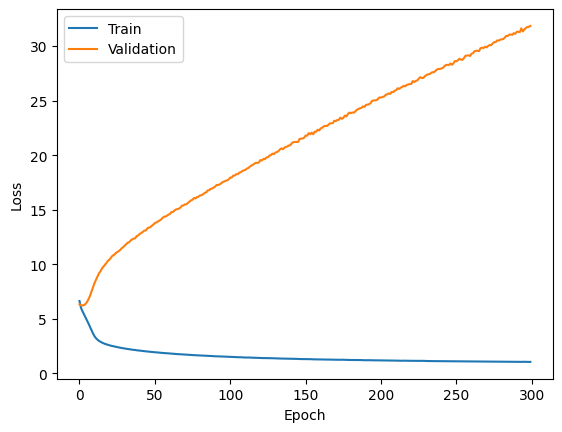

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [11]:
def predict_next(context_words, model, top_k=5):
    model.eval()

    # enforce correct context size
    if len(context_words) < CONTEXT_SIZE:
        context_words = ["<UNK>"] * (CONTEXT_SIZE - len(context_words)) + context_words # fills the missing elments with unknown
    else:
        context_words = context_words[-CONTEXT_SIZE:] # consider only the context length of words from the end of the array

    idxs = torch.tensor([[
        word_to_ix.get(w, word_to_ix["<UNK>"])
        for w in context_words
    ]]).to(device) # if the word is in vocabulary give the index otherwise use the index for unknown

    logits = model(idxs) # ouputs raw scores for every word in the vocabulary
    probs = F.softmax(logits, dim=1) # gives soft max probabilities for each output

    top = torch.topk(probs, top_k) # top k predictions will be displayed
    return [(ix_to_word[i.item()], top.values[0][j].item())
            for j, i in enumerate(top.indices[0])] # converts indices back to words


In [12]:
print(predict_next(["to", "be", "or"], model))
print(predict_next(["to", "be", "or", "not", "to"], model))


[('in', 0.18911075592041016), ('to', 0.1734001338481903), ('a', 0.1520916223526001), ('on', 0.12987367808818817), ('of', 0.1166117936372757)]
[('be', 0.48194441199302673), ('have', 0.10440786927938461), ('the', 0.058346621692180634), ('whom', 0.04003780335187912), ('any', 0.03822555020451546)]


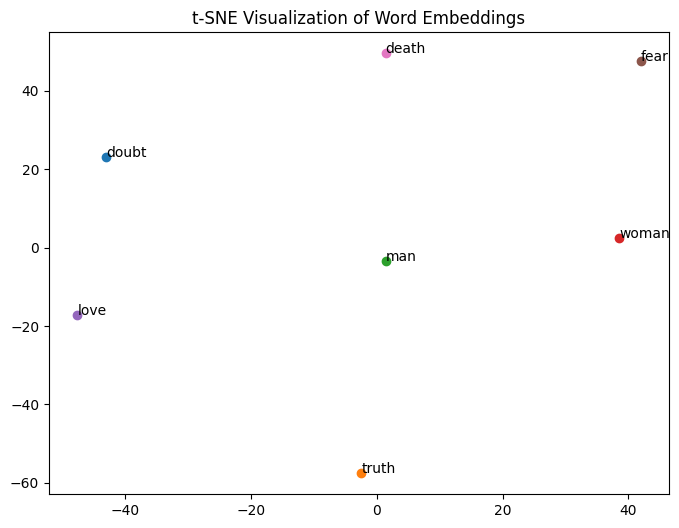

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Select a small set of meaningful words
selected_words = ["doubt", "truth", "man", "woman", "love", "fear", "death"]
selected_words = [w for w in selected_words if w in word_to_ix]

indices = [word_to_ix[w] for w in selected_words]

# Extract embeddings
embeddings = model.embedding.weight[indices].detach().cpu().numpy()

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
emb_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 6))
for i, word in enumerate(selected_words):
    x, y = emb_2d[i]
    plt.scatter(x, y)
    plt.text(x + 0.02, y + 0.02, word)

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()


In [15]:
torch.save({
    "model_state_dict": model.state_dict(),
    "vocab": vocab,
    "word_to_ix": word_to_ix,
    "ix_to_word": ix_to_word,
    "context_size": CONTEXT_SIZE,
    "embedding_dim": EMBED_DIM,
    "hidden_dim": HIDDEN_DIM
}, "next_word_mlp_sherlock.pth")

# saving in .pth files to run futher in vs code(for streamlit)
